# Group Members





### Dongyan Lin
McGill ID 260669424

dongyan.lin@mail.mcgill.ca

### Justin Dumouchelle
McGill ID 260954626

justin.dumouchelle@mail.mcgill.ca

For the coding questions, question 1A and 2A were completed.  

# Question 1A

In [0]:
import numpy as np
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt

In [0]:
class Arms(object):
    
    def __init__(self, k):
        '''
            Constructor which defines the number of arms and mean of each arm.  
            Params:
                k - an integer indicating the number of arms.
        '''
        self.k = k
        self.arm_means = np.zeros(self.k)

        # initialize means for each of the k arms
        self.arm_means = np.random.normal(0,1, size=(self.k))
        
        return
        
    def get_reward(self, i):
        '''
            Samples a reward for the i-th arm from N(mu_i, 1).
            Params:
                i - an integer indicating the arm to sample.
            Returns:
                a value sampled from the i-th arm.
        '''
        return np.random.normal(self.arm_means[i], 1)

In [0]:
class UCBBandit(object):
    
    def __init__(self, k, c):    
        '''
            Constructor for a UCB bandit.  
            Params: 
                k - an integer indicating the number of arms.
                c - a float for the hyperparamter in UCB settings.  
        '''
        self.k = k
        self.c = c
        
        self.t = 1
        self.Q_t = np.zeros(self.k)
        self.N_t = np.zeros(self.k)

        return
  
    def get_action(self):
        '''
            Chooses the action with the largest UCB.  Choosed the action which maximizes expectation of reward
            plus the c*sqrt(log(t)/N(t)).
        '''
        
        ucb = self.Q_t + self.c * np.sqrt( np.log(self.t) / (self.N_t+1e-10 ) )
        
        # choose an action that is maximal, with ties broken randomly.  
        A_t = np.argmax(np.random.random(ucb.shape) * (ucb == ucb.max()))

        return A_t
    
    def update(self, A_t, R_t):
        '''
            Using the reward and action, this recomputes the t, N_t(a), and Q_t(a).
            Params:
                A_t - an integer of the action taken at time t.
                R_t - a float of the reward from the resulting action.
        '''
        self.t += 1
        self.N_t[A_t] += 1
        self.Q_t[A_t] = self.Q_t[A_t] + 1/self.N_t[A_t]*(R_t - self.Q_t[A_t])

        return
    
    
    def get_best_action(self):
        '''
            Gets the optimal action based on the highest Q value so far.
        '''
        return np.argmax(self.Q_t)
        

In [0]:
class BoltzmannBandit(object):
    
    
    def __init__(self, k, alpha, temp):    
        '''
            Constructor for a Boltzmann bandit.  This implementation of the boltzmann bandit is based
            on a distribution defined by the preferences for a gradient based bandit.  
            Params: 
                k - an integer indicating the number of arms.
                alpha - learning rate.
                temp - temperature for boltzmann distribution.
        '''
        self.k = k
        self.alpha = alpha
        self.temp = temp

        self.t = 1
        self.H_t = np.zeros(self.k)
        self.N_t = np.zeros(self.k)
        self.bar_R_t = np.zeros(self.k)
        self.pi_t = np.zeros(self.k)

        return
        
    def get_action(self):
        '''
            Define prob. dist pi_t, and sample to obtain arm.
        '''
        
        self.pi_t = np.exp(self.H_t / self.temp) / np.exp(self.H_t / self.temp).sum()
        choices = list(range(self.pi_t.shape[0]))
        
        A_t = np.random.choice(choices, 1, p=self.pi_t)

        return A_t
    
    
    def update(self, A_t, R_t):
        '''
            Using the reward and action, this recomputes the t, N_t(a), bar_R_t(a), and Q_t(a).
            Params:
                A_t - an integer of the action taken at time t.
                R_t - a float of the reward from the resulting action.
        '''
        
        self.t += 1
        self.N_t[A_t] += 1
        self.bar_R_t[A_t] = ((self.N_t[A_t] -1) * self.bar_R_t[A_t] + R_t)/self.N_t[A_t] 

        # update learned preference H_t
        for a in range(self.k):
            if a == A_t:
                self.H_t[a] = self.H_t[a] + self.alpha * (R_t - self.bar_R_t[a]) * (1 - self.pi_t[a])
            else:
                self.H_t[a] = self.H_t[a] - self.alpha * (R_t - self.bar_R_t[a]) * self.pi_t[a]
                
        return
  
    
    def get_best_action(self):
        '''
            Gets the optimal greedy action based on the highest preference arm so far.
        '''
        return np.argmax(self.H_t)
        

In [0]:
class ThompsonBandit(object):
    
    
    def __init__(self, k, sigma):    
        '''
            Constructor for Thompson sampling based bandit.  Note that in this implementation
            the prior distribution is a N(0,1) distributiuon.  The variance is also assumed to be know
            as 1, allowing to update the prior simply following from this thread:
                https://mycourses2.mcgill.ca/d2l/le/429930/discussions/threads/706403/View
            The prior updates and posterior computation were defined from this resource:
                https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf
            Params: 
                k - an integer indicating the number of arms.
                sigma - the standard deviation for each arms prior dist.  
        '''

        self.k = k
        self.sigma = sigma

        self.t = 1
        self.N_t = np.zeros(self.k)
        
        self.prior_mu = np.ones(self.k)
        self.prior_sigma = self.sigma*np.ones(self.k)
        
        # since prior dist has mu=0 and no samples the posterior has the simple form
        self.posterior_mu = np.ones(self.k)
        self.posterior_sigma = self.sigma*np.ones(self.k)
        
        self.sum_x_i = np.zeros(self.k)

        return
      
    def get_action(self):
        '''
            Chooses the action by sampling from each posterior and choosing the maximum.
        '''
        sampled_rewards = np.zeros(self.k)
        for a in range(self.k):
            sampled_rewards[a] = np.random.normal(self.posterior_mu[a], np.sqrt(self.posterior_sigma[a]))

        return np.argmax(sampled_rewards)
    
    
    def update(self, A_t, R_t):  
        '''
            Using the reward and action, this recomputes the t, N_t(a), bar_R_t(a), and Q_t(a).
            Note that since we are consider the posterior to have know standard deviation of 1, the
            update can the posterior mean can be simplified to the below form.  
                Params:
                  A_t - an integer of the action taken at time t.
                  R_t - a float of the reward from the resulting action.
        '''
        self.t += 1
        self.N_t[A_t] += 1        
        self.sum_x_i[A_t] += R_t
        
        # update prior
        mu_new = (1 * self.prior_mu[A_t] + self.prior_sigma[A_t] * R_t ) / (1 + self.prior_sigma[A_t])
        sigma_new = np.sqrt((1 * self.prior_sigma[A_t]) / (1 + self.prior_sigma[A_t]))
        
        self.prior_mu[A_t] = mu_new
        self.prior_sigma[A_t] = sigma_new
        
        # update posterior
        a = 1 / (1/self.prior_sigma[A_t]**2 + self.N_t[A_t]/1)
        b = (self.prior_mu[A_t]/self.prior_sigma[A_t] **2 + self.sum_x_i[A_t]/1)
        
        c = 1 / (1/self.prior_sigma[A_t]**2 + self.N_t[A_t]/1)
        
        self.posterior_mu[A_t] = a * b
        self.posterior_sigma[A_t] = c
    
        return
    
    
    def get_best_action(self):
        '''
            Gets the optimal greedy action based on the highest posterior mean so far.
        '''
        return np.argmax(self.posterior_mu)

      

In [0]:
def train_bandit(bandit_type, bandit_params, k=10, runs=10, iters=1000, pulls_to_average_over=5, test_freq=10, seed=1234):
    '''
        Trains a bandit and records all nessecary components for plotting results over time.
        Params:
            bandit_type - a string indicating the type of bandit
            bandit_params - a dictionary containing the parameters for the bandit
            k - an integer indicating the number of arms
            runs - the number of runs to average over
            iters - the number of iterations to train over
            pulls_to_average_over - number of arms to average reward over for test instances
            test_freq - frequency to test greedy policy
            seed - seed used for reproducability
        Returns:
            a dictionary containing all results needed for plotting preformance.  
    '''

    # define placeholders for results
    rewards = np.zeros((runs, iters))
    actions = np.zeros((runs, iters))
    test_rewards = np.zeros((runs, iters // test_freq))
    test_actions = np.zeros((runs, iters // test_freq))

    # initialize arms
    np.random.seed(seed)
    arms = Arms(k)

    for run in range(0, runs):
        
        # initalize type of bandit
        if bandit_type == 'ucb':
            bandit = UCBBandit(k=k, **bandit_params)
        elif bandit_type == 'boltzmann':
            bandit = BoltzmannBandit(k=k, **bandit_params)
        else:
            bandit = ThompsonBandit(k=k, **bandit_params)

        # training phase
        for i in range(0, iters):

            # get action, reward, and update
            A_t = bandit.get_action()
            R_t = arms.get_reward(A_t)
            bandit.update(A_t, R_t)

            # record train reward and action
            rewards[run][i] = R_t
            actions[run][i] = A_t

            # get test reward at every test_freq iteration
            if i % test_freq == 0:

                # get reward of best action averaged over pulls_to_average_over pulls
                best_action = bandit.get_best_action()
                test_R_t = []
                for _ in range(pulls_to_average_over):
                    test_R_t.append(arms.get_reward(best_action))
                
                # record test reward and action
                test_actions[run, i//test_freq] = best_action
                test_rewards[run, i//test_freq] = np.mean(test_R_t)


    # define average reward for training data
    avg_rewards = rewards.mean(axis=0)
    std_rewards = np.std(rewards, axis=0)
    
    # define optimal actions for training data
    opt_action = np.argmax(arms.arm_means)
    percent_opt = (actions == opt_action).mean(axis=0)
    std_pct_opt = np.std((actions == opt_action))
    
    # average regret +/- std
    opt_mean = np.max(arms.arm_means)
    reg = opt_mean * np.ones(actions.shape)
    for i in range(actions.shape[0]):
        for j in range(actions.shape[1]):
            reg[i][j] -= arms.arm_means[int(actions[i][j])]
    
    avg_regret = reg.mean(axis=0)
    std_regret = np.std(reg, axis=0)
    
    # define average reward for testing data
    avg_test_rewards = test_rewards.mean(axis=0)
    std_test_rewards = np.std(test_rewards, axis=0)
    
    result_dict = {
        'avg_rewards' : avg_rewards,
        'std_rewards' : std_rewards,
        
        'percent_opt' : percent_opt,
        'std_pct_opt' : std_pct_opt,
        
        'avg_regret' : avg_regret,
        'std_regret' : std_regret,

        'avg_test_rewards' : avg_test_rewards,
        'std_test_rewards' : std_test_rewards,

        'bandit' : bandit,
        'arms' : arms
    }
    
    return result_dict

In [0]:
def plot_hyperparameter_set(bandit_type, param_dict, k=10, runs=10, iters=1000, pulls_to_average_over=5, test_freq=10, seed=1234):
    '''
      Plots bandit preformance over a given set of hyperparameters.
        Params:
            bandit_type - a string indicating the type of bandit
            param_dict - a dictionary containing the parameter as a key and the list of values as a value.
            k - an integer indicating the number of arms
            runs - the number of runs to average over
            iters - the number of iterations to train over
            pulls_to_average_over - number of arms to average reward over for test instances
            test_freq - frequency to test greedy policy
            seed - seed used for reproducability
    '''

    # store results over each set of hyperparameters
    all_results = {}

    if bandit_type == 'boltzmann':
        for a in param_dict['alpha']:
            for t in param_dict['temp']:
                key = 'alpha' + '=' + str(a) + ', temp=' + str(t)
                bandit_params = {'alpha' : a, 'temp': t}
                all_results[key] = train_bandit(bandit_type, bandit_params, k=k, runs=runs, iters=iters, pulls_to_average_over=pulls_to_average_over, test_freq=test_freq, seed=seed)

    elif bandit_type == 'ucb':
        for c in param_dict['c']:
            key = 'c' + '=' + str(c) 
            bandit_params = {'c' : c}
            all_results[key] = train_bandit(bandit_type, bandit_params, k=k, runs=runs, iters=iters, pulls_to_average_over=pulls_to_average_over, test_freq=test_freq, seed=seed)

    elif bandit_type == 'thompson':
        for sigma in param_dict['sigma']:
            key = 'sigma' + '=' + str(sigma) 
            bandit_params = {'sigma' : sigma}
            all_results[key] = train_bandit(bandit_type, bandit_params, k=k, runs=runs, iters=iters, pulls_to_average_over=pulls_to_average_over, test_freq=test_freq, seed=seed)
            
            
    # plot
    test_idx = list(range(0, iters, test_freq))

    fig, ax = plt.subplots(nrows=4, ncols=1)

    fig.set_figheight(20)
    fig.set_figwidth(15)

    count = 0

    for row in ax:

        if count == 0:

            for key, v in all_results.items():
                row.plot(v['avg_rewards'], label=key)

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Return')
            row.set_title('Average Return per step')

        elif count == 1:

            for key, v in all_results.items():
                row.plot(100*v['percent_opt'], label=key)

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('% optimal')
            row.set_title('Percent Optimal per step')

        elif count == 2:


            for key, v in all_results.items():
                row.plot(v['avg_regret'], label=key)

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Regret')
            row.set_title('Average Regret Per Step')

        elif count == 3:

            for key, v in all_results.items():
                row.plot(test_idx, v['avg_test_rewards'], label=key)

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Reward')
            row.set_title('Test Average Reward over 5 pulls (every 10 pulls)')

        count += 1

    fig.suptitle(bandit_type + ' bandit')

    plt.show()
    
    return
    

In [0]:
def plot_results(bandit_type, result_dict):
    '''
        Plots results for a given bandit.  The average reward, % optimal, average regret, and test reward are
        all plotted.  
        Params:
            bandit_type - a string indicating the bandit type
            result_dict -  a dictionary obtained form the 
    '''
    
    test_idx = list(range(0, result_dict['avg_rewards'].shape[0], 10))

    fig, ax = plt.subplots(nrows=4, ncols=1)

    fig.set_figheight(20)
    fig.set_figwidth(15)

    count = 0

    for row in ax:

        if count == 0:
            
            # plot average return +/- std
            row.plot(result_dict['avg_rewards'] + result_dict['std_rewards'], 'y', linestyle=':', label='mean +/- std')
            row.plot(result_dict['avg_rewards'] - result_dict['std_rewards'], 'y', linestyle=':')
            row.plot(result_dict['avg_rewards'], 'b', label='average return')

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Return')
            row.set_title('Average Return per step')

        elif count == 1:
            
            
            # plot % optimal 
            row.plot(100*result_dict['percent_opt'], 'b')
                  
                
            row.set_xlabel('Iteration')
            row.set_ylabel('% optimal')
            row.set_title('Percent Optimal per step')

        elif count == 2:
            
            # plot average regret +/- std
            row.plot(result_dict['avg_regret'] + result_dict['std_regret'], 'y', linestyle=':', label='mean +/- std')
            row.plot(result_dict['avg_regret'] - result_dict['std_regret'], 'y', linestyle=':')
            row.plot(result_dict['avg_regret'], 'b', label='average regret')
            
            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Regret')
            row.set_title('Average Regret Per Step')
            
        elif count == 3:
            
            # plot average test reward (+/- std) over 5 pulls  every 10 iterations
            row.plot(test_idx, result_dict['avg_test_rewards'] + result_dict['std_test_rewards'], 'y', linestyle=':', label='mean +/- std')
            row.plot(test_idx, result_dict['avg_test_rewards'] - result_dict['std_test_rewards'], 'y', linestyle=':')
            row.plot(test_idx, result_dict['avg_test_rewards'], 'b', label='average test reward')

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Reward')
            row.set_title('Test Average Reward over 5 pulls (every 10 pulls)')

        count += 1

    fig.suptitle(bandit_type + ' bandit')

    plt.show()

In [0]:
def plot_all_results(result_dict_boltzmann, result_dict_ucb, result_dict_thompson):
    '''
        Plots a comparison of all models training and test. 
        Params:
            result_dict_boltzmann - a dictionary of the Boltzmann results.
            result_dict_ucb - a dictionary of the UCB results.
            result_dict_thompson - a dictionary of the Thompson results.
    '''
    
    test_idx = list(range(0, result_dict_boltzmann['avg_rewards'].shape[0], 10))

    fig, ax = plt.subplots(nrows=4, ncols=1)

    fig.set_figheight(30)
    fig.set_figwidth(15)

    count = 0

    for row in ax:

        if count == 0:

            # plot average return
            row.plot(result_dict_boltzmann['avg_rewards'], 'b', label='Boltzmann')
            row.plot(result_dict_ucb['avg_rewards'], 'r', label='UCB')
            row.plot(result_dict_thompson['avg_rewards'], 'y', label='Thompson')

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Return')
            row.set_title('Average Return per step')

        elif count == 1:
            
            # plot percent optimal
            row.plot(result_dict_boltzmann['percent_opt'], 'b', label='Boltzmann')
            row.plot(result_dict_ucb['percent_opt'], 'r', label='UCB')
            row.plot(result_dict_thompson['percent_opt'], 'y', label='Thompson')
    
            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('% optimal')
            row.set_title('Percent Optimal per step')
            
        elif count == 2:
            
            # plot average regret
            row.plot(result_dict_boltzmann['avg_regret'], 'b',  label='Boltzmann')
            row.plot(result_dict_ucb['avg_regret'], 'r', label='UCB')
            row.plot(result_dict_thompson['avg_regret'], 'y', label='Thompson')

            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Regret')
            row.set_title('Average Regret Per Step')

        elif count == 3:

            # plot average test reward
            row.plot(test_idx, result_dict_boltzmann['avg_test_rewards'], 'b', label='Boltzmann')
            row.plot(test_idx, result_dict_ucb['avg_test_rewards'], 'r', label='UCB')
            row.plot(test_idx, result_dict_thompson['avg_test_rewards'], 'y', label='Thompson')
                  
            row.legend()
            row.set_xlabel('Iteration')
            row.set_ylabel('Reward')
            row.set_title('Test Average Reward over 5 pulls (every 10 pulls)')
            
        count += 1

    plt.show()

## Init

In [0]:
runs = 10
iters = 1000
seed = 1234

## Boltzmann Bandit

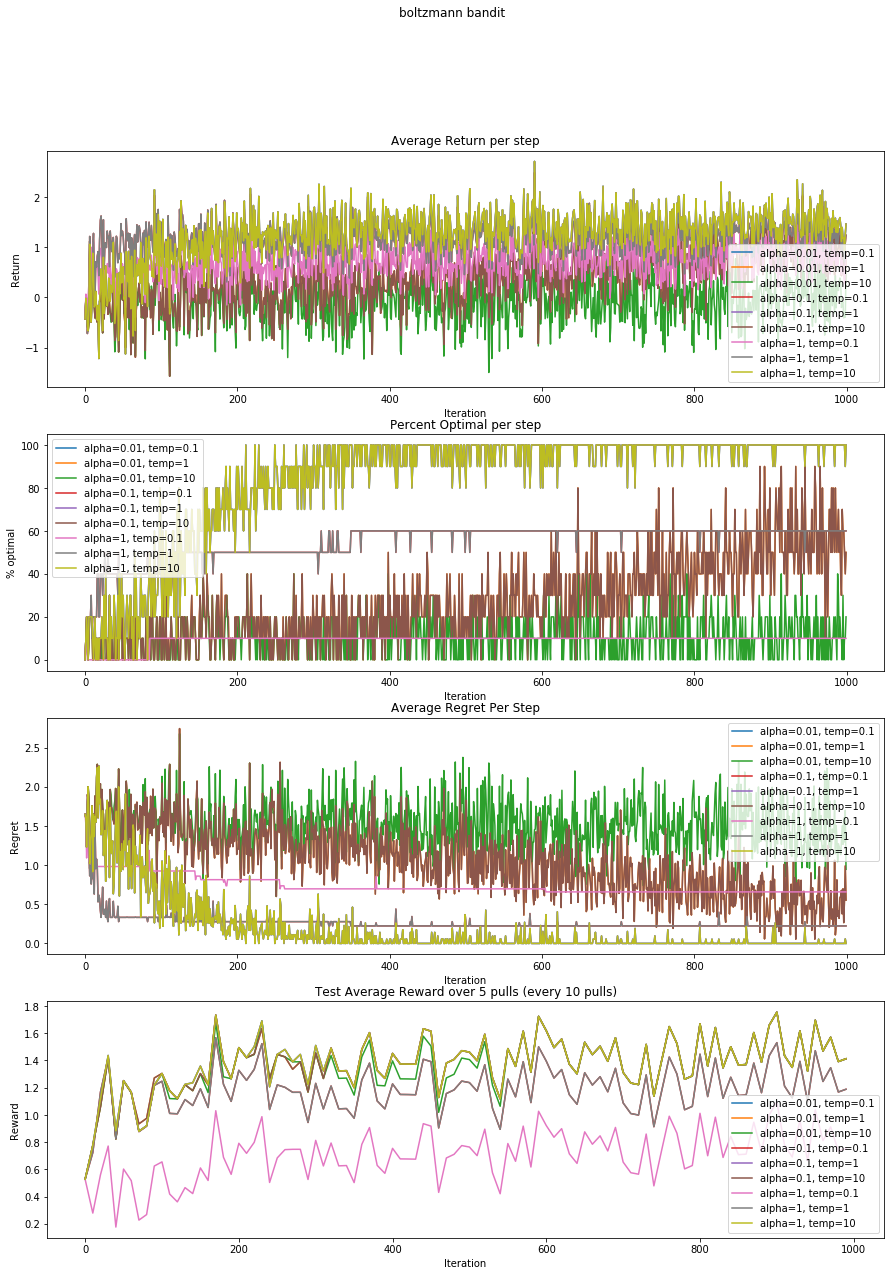

In [11]:
# hyperparameter search
bandit_type = 'boltzmann'

param_dict = {
    'alpha' : [0.01, 0.1, 1],
    'temp' : [0.1, 1, 10]
}

plot_hyperparameter_set(bandit_type, param_dict, runs=runs, iters=iters)

From the hyperparameter set plot, we narrowed down the hyperparameter candidates to: {alpha=0.01, temp=0.1}, {alpha=0.1, temp=1}, and {alpha=1, temp=10}. These three pairs of hyperparameters produced same results on the average and maximum reward achieved during test, so we will use {alpha=0.1, temp=1} as the tuned Boltzmann hyperparameters to conduct algorithm comparison.

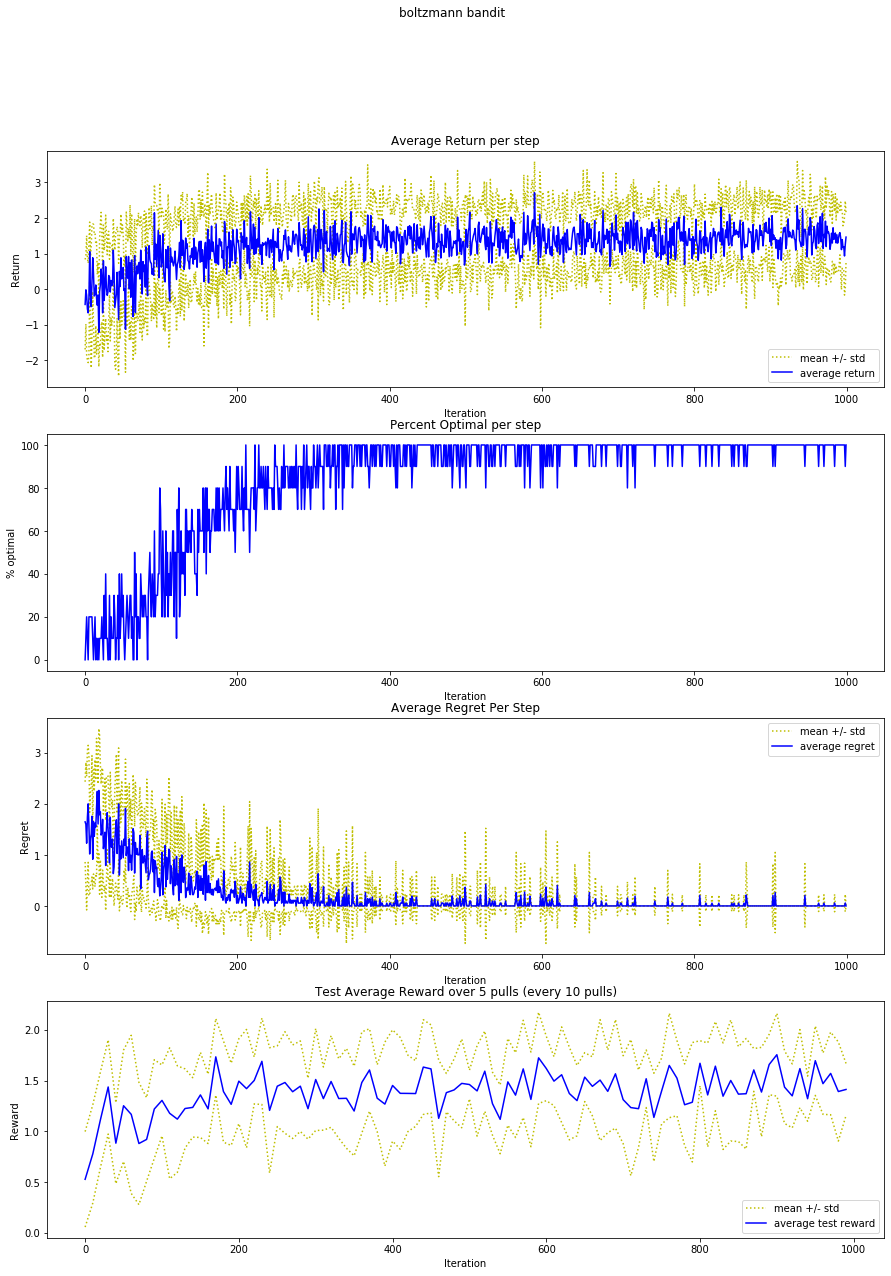

In [12]:
bandit_type = 'boltzmann'

bandit_params = {'alpha' : 0.1, 
                 'temp' : 1}

result_dict_boltzmann = train_bandit(bandit_type, bandit_params, runs=runs, iters=iters, seed=seed)

plot_results(bandit_type, result_dict_boltzmann)

## UCB Bandit

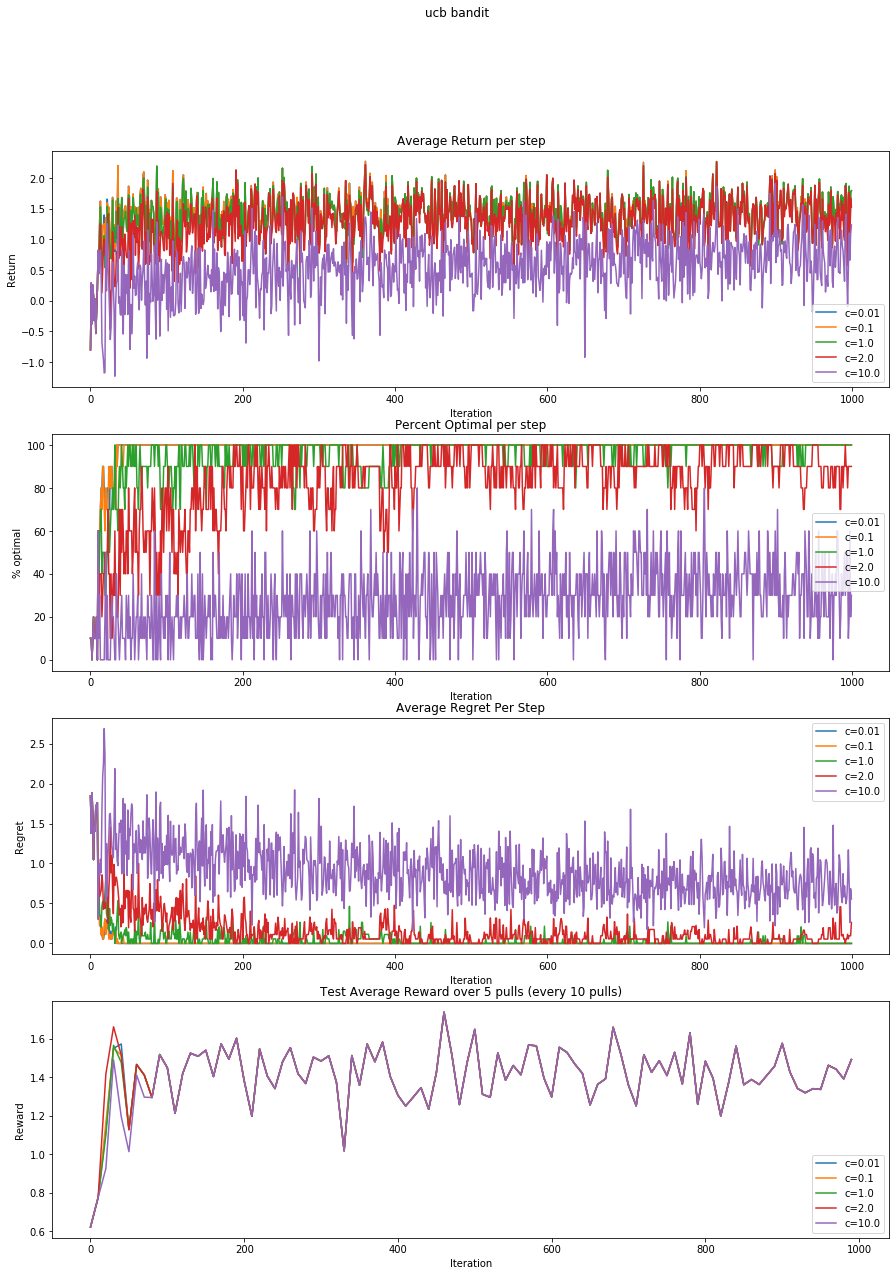

In [13]:
# hyperparameter search
bandit_type = 'ucb'

param_dict = {
    'c' : [0.01, 0.1, 1.0, 2.0, 10.0],
}

plot_hyperparameter_set(bandit_type, param_dict, runs=runs, iters=iters)

We first tried a few hyperparameters to narrow down the range, based on the shape of the three plots during training (i.e. whether the values converge, how fast the values converge, etc.): average training return, percent optimal per step, and average regret per step. For UCB, we have narrowed down the range to c ∈ [0.01, 2]. 

Once we have a narrower range, we perform a grid search. we choose the average reward achieved over all iterations **during test** as the metric.



In [14]:
candidates = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
outputs = []

for candidate in candidates:
  bandit_type = 'ucb'
  bandit_params = {'c' : candidate}
  result_dict_ucb = train_bandit(bandit_type, bandit_params, runs=runs, iters=iters, seed=seed)
  outputs.append(result_dict_ucb['avg_test_rewards'].mean(axis=0))

print(candidates[outputs.index(max(outputs))])

1.8


As a result, we select c=1.8 as the tuned UCB hyperparameter for algorithm comparison.

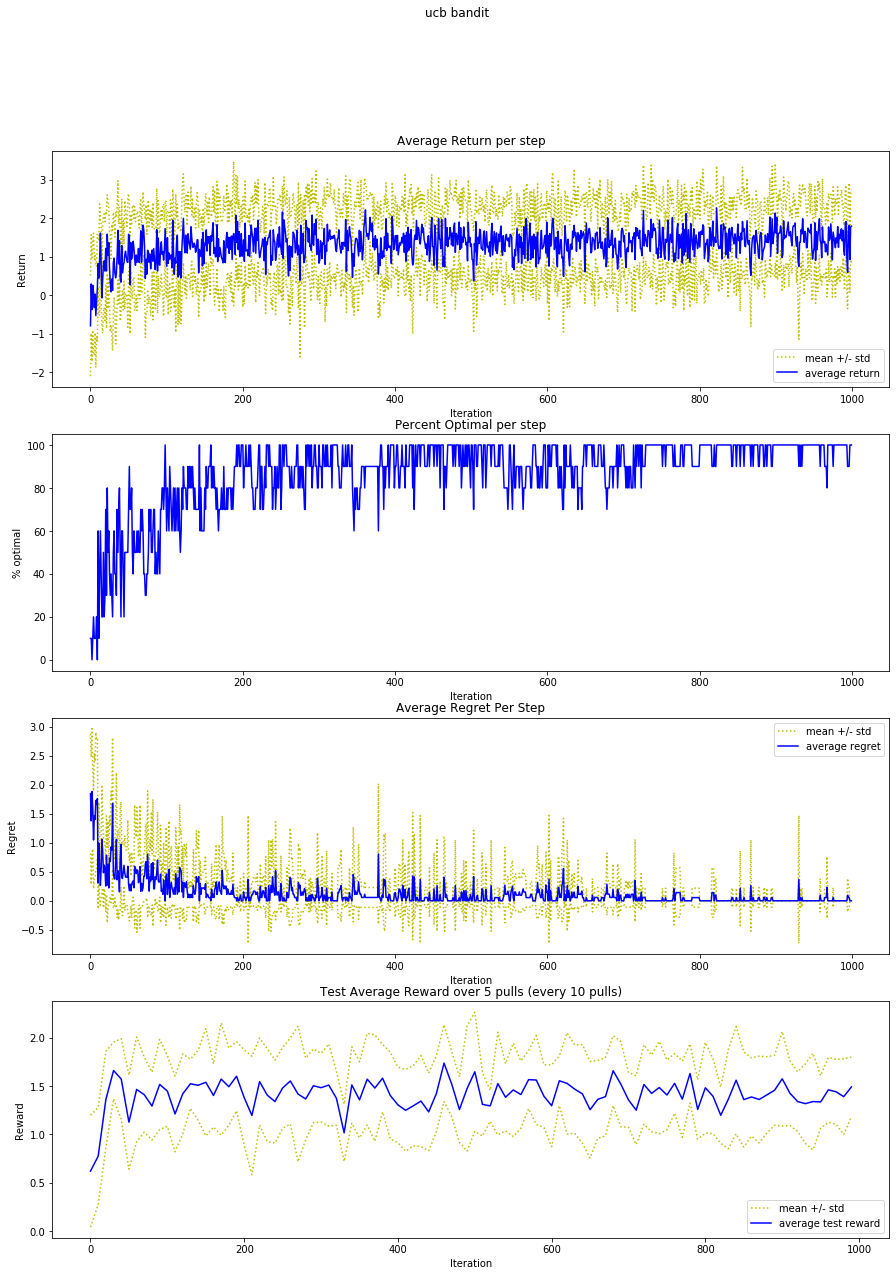

In [15]:
bandit_type = 'ucb'
bandit_params = {'c' : 1.8}

result_dict_ucb = train_bandit(bandit_type, bandit_params, runs=runs, iters=iters, seed=seed)

plot_results(bandit_type, result_dict_ucb)

## Thompson Bandit

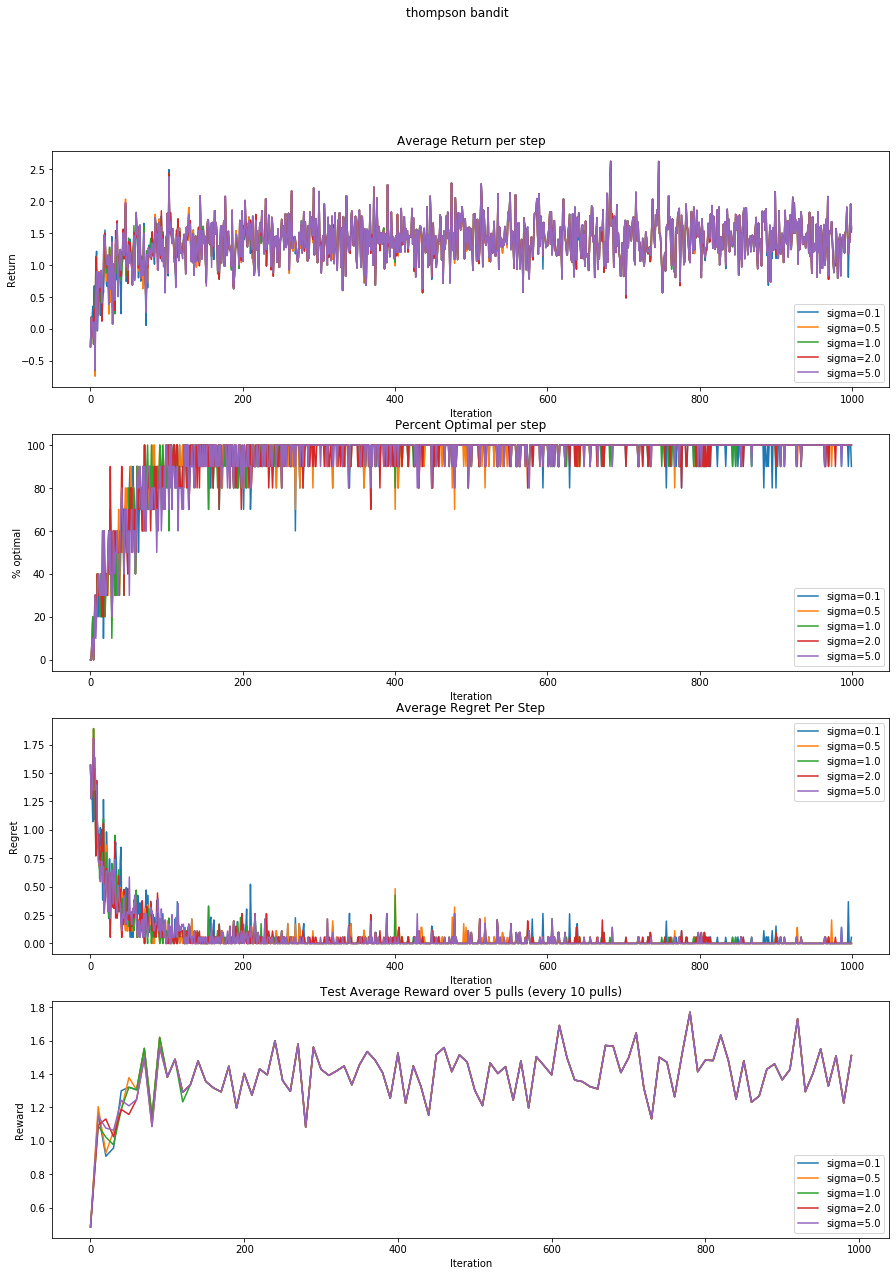

In [16]:
# hyperparameter search
bandit_type = 'thompson'

param_dict = {
    'sigma' : [0.1, 0.5, 1.0, 2.0, 5.0],
}

plot_hyperparameter_set(bandit_type, param_dict, runs=runs, iters=iters)

Since different sigma hyperparameters produced similar result, we will use them as candidates and search for the one that gives the highest average reward during test.

In [17]:
candidates = [0.1,0.5,1,2,5]
outputs = []

for candidate in candidates:
  bandit_type = 'thompson'
  bandit_params = {'sigma' : candidate}
  result_dict_thompson = train_bandit(bandit_type, bandit_params, runs=runs, iters=iters, seed=seed)
  outputs.append(result_dict_thompson['avg_test_rewards'].mean(axis=0))
  
print(candidates[outputs.index(max(outputs))])

0.5


As a result, we select sigma=0.5 to be the tuned Thompson hyperparameter for algorithm comparison.

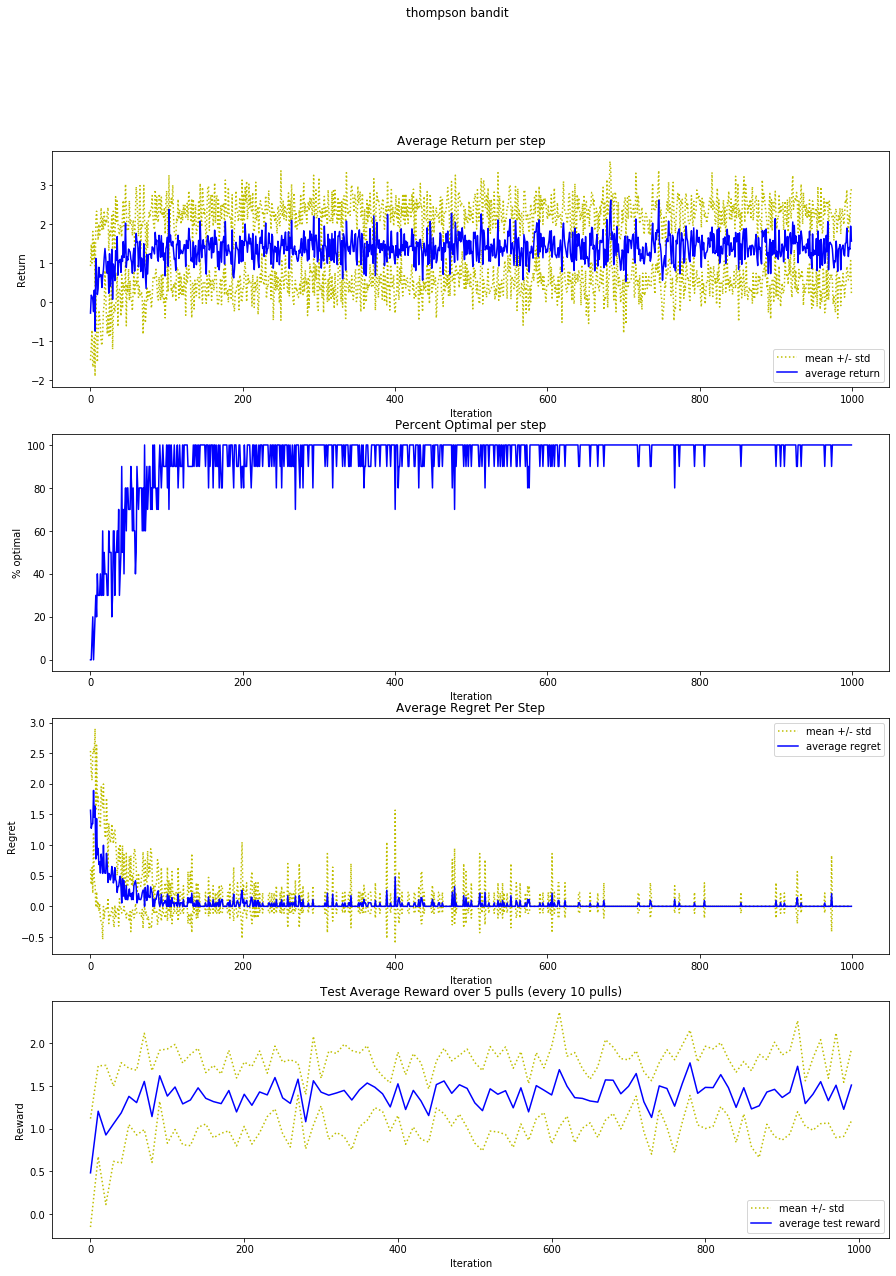

In [18]:
bandit_type = 'thompson'
bandit_params = {'sigma' : 0.5}

result_dict_thompson = train_bandit(bandit_type, bandit_params, runs=runs, seed=seed)

plot_results(bandit_type, result_dict_thompson)

## Plot all

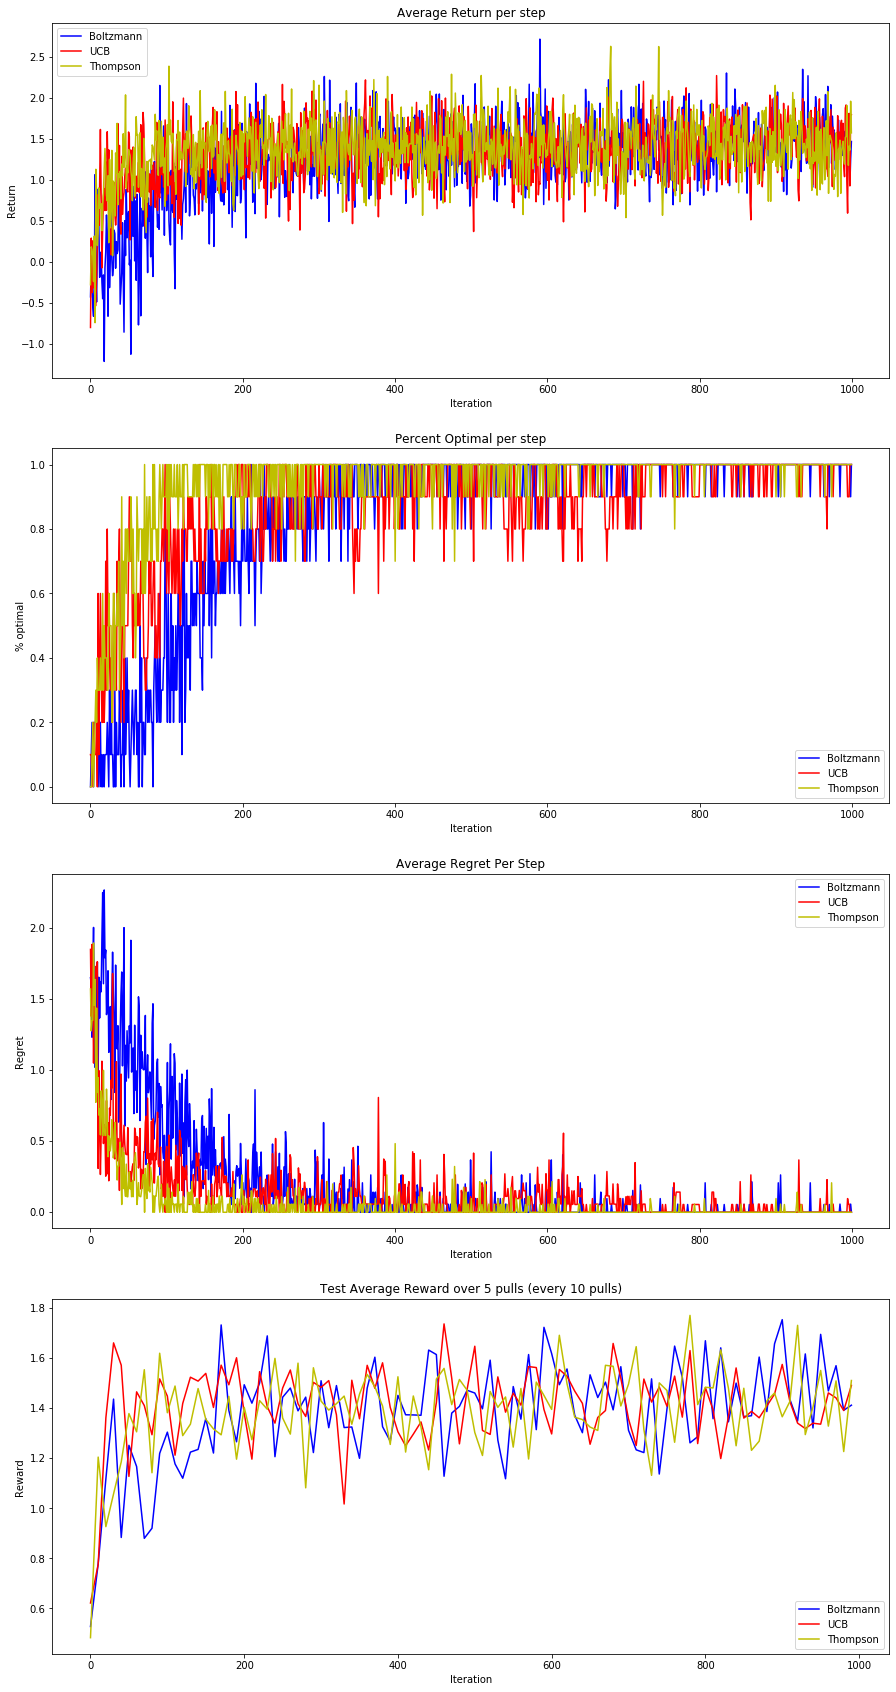

In [19]:
plot_all_results(result_dict_boltzmann, result_dict_ucb, result_dict_thompson)

We expected that UCB would perform suboptimally for being optimistic in face of uncertainty. Thompson sampling and Boltzmann exploration would have different rates for convergence, and stabilize at different values as a trade-off.

As shown in the plots with the tuned hyperparameters (c=1.8 for UCB, alpha=0.1 and temp=1 for Boltzmann, sigma=0.5 for Thompson sampling), all three algorithms produced similar average return per step during training, as well as average reward during test. During training, Thompson sampling was the fastest one to converge to optimal value, but its optimal value might not be as good as that achieved by Boltzmann exploration. On the other hand, Boltzmann exploration is the slowest one to converge, but once it stabilizes, Boltzmann exploration produced the highest % optimal per step and the lowest average regret per step. UCB was not as stable or optimal compared to Boltzmann exploration and Thompson sampling. The high variance in all three algorithms was due to the limited number of runs (10).

# Question 2A

For this question two enviornments in OpenAI gym will be used.  FrozenLake and Taxi are the two enviornments which this section will focus on.  

Frozen lake is a 4x4 grid based enviornment where a player has to move to the opposite end grid while avoiding holes.  They agent receives a return of 1 if the they successfully make it to the opposite side and a return of 0 otherwise.

Taxi is a game which involves picking up and dropping off a player.  For a successful dropoff the reward is 20, while for each time step a reward of -1 is receieved.  In addition there are traffic rules which must be considered, otherwise a penalty of -10 will be received.  Thus the total return is the summation of the successful dropoff minus the time and traffic violations.  

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gym

In [0]:
class PolicyIteration(object):
    
    def __init__(self, env, gamma, theta, env_max_iter, train_runs=5, test_runs=5, test_freq=10, seed = 1234):
        '''
            Constructor for Policy iteration.  Initalizes paramters for policy iteration. 
            Params:
                env - a gym enviornment to preform policy iteration on 
                gamma - a float of the reward decay
                theta - a float of the threshold to stop policy evaluation
                env_max_iter - maximum number of iterations for the enviornment
                train_runs - number of training runs to be averaged over
                test_runs - number of testing runs to be averaged over
                test_freq - freqency to preform testing at
                seed -  random seed for initalization of pi
        '''
        
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.env_max_iter = env_max_iter
        self.train_runs = train_runs
        self.test_runs = test_runs
        self.test_freq = test_freq
        self.seed = seed
        self.iters = 1
        
        self.states = list(range(self.env.observation_space.n))
        self.actions = list(range(self.env.action_space.n))
        
        self.train_rewards = []
        self.train_std_rewards = []
        self.train_iters = []
        self.train_std_iters = []
        
        self.test_rewards = []
        self.test_std_rewards = []
        self.test_iters = []
        self.test_std_iters = []
        
        return
        
        
    def initialize(self):
        '''
            Initialize step of policy iteration.  Initialize a random action for each state
            and a value vector of zeros.  
        '''
        
        np.random.seed(self.seed)
        self.pi = np.random.randint(low=0, high = len(self.actions), size =len(self.states))
        self.v = np.zeros(len(self.states))
        
        # record results of random policy
        self.get_results('train')
        self.get_results('test')
        
        return
        
        
    def policy_evaluation(self):
        '''
            Preforms the policy evaulation step to update v until convergence to delta.  This is directly
            based on the course slide pseudocode.  
        '''
        
        while True:

            delta = 0

            # update v[s] for each state
            for s in self.states:

                v_s = self.v[s]
                self.v[s] = self.compute_Vs_update(s)

                if np.abs(v_s - self.v[s]) > delta:
                    delta = np.abs(v_s - self.v[s])

            # stop once all state updates are below delta
            if delta < self.theta:
                break
            
        return
    
    
    def policy_improvement(self):
        '''
            Preforms policy evaluation, then policy improvement.  This function is called recursively
            until convergence on the policy is obtained.  This is directly based on the course slides pseudocode.
            Returns: 
                a tuple of the values and action for each state
        '''        
        self.policy_evaluation()
        policy_stable = True
        
        # check if policy is stable
        for s in self.states:
            
            old_action = self.pi[s]
            self.pi[s] = self.compute_argmax_a(s)
            
            if old_action != self.pi[s]:
                policy_stable = False
      
        # get results for training and testing if required
        self.get_results(result_type='train')

        if self.iters % self.test_freq == 0:
            self.get_results(result_type='test')
                
        self.iters += 1

        # if not stable, then preform another policy eval/improvement iteration
        if not policy_stable:
            self.policy_improvement()
            
        return self.v, self.pi
            
        
        
    def get_results(self, result_type):
        '''
            Evaluates the preformance of the current value iteration step on the enviornment.
            The policy evaluated is with respect to the current greedy choice from value iteration.    
            Params:
                result_type - the type of result that is to be recorded, either 'train' or 'test'
        '''
        
        if result_type == 'train':
            episodes = self.train_runs
        elif result_type == 'test':
            episodes = self.test_runs

        rewards = []
        iters = []
        
        # iter over the number of train/test runs to get average reward/iters_to_solve
        for episode in range(episodes):
            
            if result_type == 'train':
                env.seed(self.seed + episode) # seed based on episode
            
            elif result_type == 'test':
                env.seed(self.seed + episode + self.train_runs) # ensure different instances in test case
                
            state = self.env.reset()

            episode_reward = 0
            episode_iters = 0

            # iterate through enviornment for env_max_iter steps
            for env_iter in range(self.env_max_iter):

                state, reward, done, info =  env.step(self.pi[state])
                episode_reward += reward
                episode_iters += 1

                if done:
                    break
                                    
            # update cumulative rewards/steps
            rewards.append(episode_reward)
            iters.append(episode_iters)

        # compute  and standard deviations
        avg_reward = np.mean(rewards)
        avg_iters = np.mean(iters)
        std_reward = np.std(rewards) 
        std_iters = np.std(iters)
        
        # store results
        if result_type == 'train':
            self.train_rewards.append(avg_reward)
            self.train_std_rewards.append(std_reward)
            self.train_iters.append(avg_iters)
            self.train_std_iters.append(std_iters)
            
        elif result_type == 'test':
            self.test_rewards.append(avg_reward)
            self.test_std_rewards.append(std_reward)
            self.test_iters.append(avg_iters)
            self.test_std_iters.append(std_iters)
            
        return
    
    
    
        
    def compute_Vs_update(self, s):
        '''
            Computes updates to v[s] for policy evaluation. 
            Params:
                s - an integer indicating the state.
            Returns:
                the updated value for v[s]
        '''
        a = self.pi[s]   
        transitions = self.env.P[s][a]

        # compute:
        #   sum_{s',r} {p(s',r | s,a) * (r + gamma * V(s'))}
        sum_ = 0
        for i in transitions:
            p = i[0]
            s_prime = i[1]
            r = i[2]

            sum_ += p * (r + self.gamma * self.v[s_prime])
 
        return sum_
        
    
    def compute_argmax_a(self, s):
        '''
            Computes the updated action for a state s with respect to a value function v.
            Params:
                s - an integer indicating the state
            Returns:
                the actions which maximises expectation
        '''
        max_arg = -1
        max_val = -1e7

        for a in self.actions:

            transitions = self.env.P[s][a]

            # compute: 
            #   sum_{s',r} {p(s',r | s,a) * (r + gamma * V(s'))}
            sum_ = 0
            for i in transitions:
                p = i[0]
                s_prime = i[1]
                r = i[2]

                sum_ += p * (r + self.gamma * self.v[s_prime])

            if sum_ >= max_val:
                max_val = sum_
                max_arg = a

        return max_arg
    
    
    def run(self):
        '''
            Runs policy iteration until convergence.  
            Returns:
                a tuple of the values and action for each state
        '''
        self.initialize()
        v, pi = self.policy_improvement()
        
        return v, pi

In [0]:
class ValueIteration(object):
    
    def __init__(self, env, gamma, theta, env_max_iter, train_runs=5, test_runs=5, test_freq=10, seed = 1234):
        '''
            Constructor for Value iteration.  Initalizes paramters for value iteration
            Params:
                env - a gym enviornment to preform policy iteration on 
                gamma - a float of the reward decay
                theta - a float of the threshold to stop policy evaluation
                env_max_iter - maximum number of iterations for the enviornment
                train_runs - number of training runs to be averaged over
                test_runs - number of testing runs to be averaged over
                test_freq - freqency to preform testing at
                seed -  random seed for initalization of pi
        '''
        
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.env_max_iter = env_max_iter
        self.train_runs = train_runs
        self.test_runs = test_runs
        self.test_freq = test_freq
        self.seed = seed
        self.iters = 1
        
        self.states = list(range(self.env.observation_space.n))
        self.actions = list(range(self.env.action_space.n))
        
        self.train_rewards = []
        self.train_std_rewards = []
        self.train_iters = []
        self.train_std_iters = []
        
        self.test_rewards = []
        self.test_std_rewards = []
        self.test_iters = []
        self.test_std_iters = []

        return
        
        
        
    def initialize(self):
        '''
            Initialize step of value iteration.  Initialize a value vector of zeros and a placeholder
            for the policy.  
        '''
        np.random.seed(self.seed)
        self.pi = np.zeros(len(self.states), dtype='int32')
        self.v = np.zeros(len(self.states))
        
        # record results of 0 initialized value function.  
        self.get_results('train')
        self.get_results('test')
        
        return
        

    def value_iteration(self,):
        '''
        Preforms the value iteration.  The implementatino directly is based on the course slides.  
        '''

        while True:

            delta = 0

            # update v[s] for each state
            for s in self.states:

                v_s = self.v[s]
                self.v[s], _ = self.compute_max_a(s)

                if np.abs(v_s - self.v[s]) > delta:
                    delta = np.abs(v_s - self.v[s])

            # stop once all state updates are below delta
            if delta < self.theta:
                break
                
            
            # get results for training and testing if required
            self.get_results(result_type='train')
            
            if self.iters % self.test_freq == 0:
                self.get_results(result_type='test')
                
            self.iters += 1
            
        # end of value iteration updates
        # define actions for each state by the action that argmax action
        for s in self.states:
            _, self.pi[s] = self.compute_max_a(s)
            self.pi[s] = self.pi[s]
            
        return self.v, self.pi    
            
        
    def get_results(self, result_type):
        '''
            Evaluates the preformance of the current value iteration step on the enviornment.
            The policy evaluated is with respect to the current greedy choice from value iteration.             
        '''
        
        if result_type == 'train':
            episodes = self.train_runs
        elif result_type == 'test':
            episodes = self.test_runs
            
        # get greedy actions corresponding to each state based on the current value function
        greedy_actions = np.zeros(len(self.states), dtype='int32')
        for s in self.states:
            _, greedy_actions[s] = self.compute_max_a(s)

        rewards = []
        iters = []
        
        # iter over the number of train/test runs to get average reward/iters_to_solve
        for episode in range(episodes):
            
            if result_type == 'train':
                env.seed(self.seed + episode) # seed based on episode
            
            elif result_type == 'test':
                env.seed(self.seed + episode + self.train_runs) # ensure different instances in test case
                
            state = self.env.reset()

            episode_reward = 0
            episode_iters = 0

            # iterate through enviornment for env_max_iter steps
            for _ in range(self.env_max_iter):

                state, reward, done, info =  env.step(greedy_actions[state])
                episode_reward += reward
                episode_iters += 1

                if done:
                    break
                    
            # update cumulative rewards/steps
            rewards.append(episode_reward)
            iters.append(episode_iters)

        # compute  and standard deviations
        avg_reward = np.mean(rewards)
        avg_iters = np.mean(iters)
        std_reward = np.std(rewards) 
        std_iters = np.std(iters)
        
        # store results
        if result_type == 'train':
            self.train_rewards.append(avg_reward)
            self.train_std_rewards.append(std_reward)
            self.train_iters.append(avg_iters)
            self.train_std_iters.append(std_iters)
            
        elif result_type == 'test':
            self.test_rewards.append(avg_reward)
            self.test_std_rewards.append(std_reward)
            self.test_iters.append(avg_iters)
            self.test_std_iters.append(std_iters)
            
        return
        
    
    def compute_max_a(self, s):
        '''
            Computes the updated action for a state s with respect to a value function v.
            Params:
                s - an integer indicating the state
            Returns:
                the max, argmax pair which maximizes the summataion.        
        '''
        
        max_arg = -1
        max_val = -1e7

        for a in self.actions:

            transitions = self.env.P[s][a]

            # compute 
            # sum_{s',r} {p(s',r | s,a) * (r + gamma * V(s'))}
            sum_ = 0
            for i in transitions:
                p = i[0]
                s_prime = i[1]
                r = i[2]

                sum_ += p * (r + self.gamma * self.v[s_prime])

            if sum_ >= max_val:
                max_val = sum_
                max_arg = a

        return max_val, max_arg
        
  
    
    def run(self):
        '''
            Runs value iteration until convergence.  
            Returns:
                a tuple of the values and action for each state
        '''
        self.initialize()
        v, pi = self.value_iteration()
        
        return v, pi

In [0]:
def plot_results(I, max_reward, min_iters, title):
    '''
        Plots train/test average reward/iterations and standard deviation.
        Params:
            I - an instance of policy of value iteration that has been run until convergence
            max_reward -  the maximal reward for the enviornment
            min_iters - the minimum number of iterations for the enviornment
            title - title for the plot
    '''
    
    train_rewards = np.array(I.train_rewards)
    train_std_rewards = np.array(I.train_std_rewards)
    train_iters = np.array(I.train_iters)
    train_std_iters = np.array(I.train_std_iters)

    test_rewards = np.array(I.test_rewards)
    test_std_rewards = np.array(I.test_std_rewards)
    test_iters = np.array(I.test_iters)
    test_std_iters = np.array(I.test_std_iters)
    
    test_idx = list(range(0, len(train_rewards), int(np.ceil(len(train_rewards) /len(test_rewards)))))
    
    fig, ax = plt.subplots(nrows=2, ncols=2)

    fig.set_figheight(12)
    fig.set_figwidth(12)

    count = 0

    for row in ax:

        for col in row:

            if count == 0:
                
                col.plot([max_reward] * len(train_rewards), 'r', linestyle=':', label='max return')
                col.plot(train_rewards + train_std_rewards , 'y', linestyle=':', label = 'mean +/- std')
                col.plot(train_rewards - train_std_rewards , 'y', linestyle=':')

                col.plot(train_rewards, 'b', label = 'average return')
                
                col.legend()
                col.set_title('Train Return')
                col.set_xlabel('iteration')
                col.set_ylabel('return')

            elif count == 1:
                
                col.plot([min_iters] * len(train_iters), 'r', linestyle=':', label='min iters')
                
                col.plot(train_iters + train_std_iters, 'y', linestyle=':', label = 'mean +/- std')
                col.plot(train_iters - train_std_iters, 'y', linestyle=':')
                
                col.plot(train_iters, 'b', label = 'average iters')
                
                col.legend()
                col.set_title('Train iterations')
                col.set_xlabel('iteration')
                col.set_ylabel('iterations per episode')

            elif count == 2:
                col.plot(test_idx, [max_reward] * len(test_rewards), 'r', linestyle=':', label='max return')
                
                col.plot(test_idx, test_rewards + test_std_rewards , 'y', linestyle=':', label = 'mean +/- std')
                col.plot(test_idx, test_rewards - test_std_rewards , 'y', linestyle=':')

                col.plot(test_idx, test_rewards, 'b', label = 'average return')
                
                col.legend()
                col.set_title('Test Return')
                col.set_xlabel('iteration')
                col.set_ylabel('return')

            elif count == 3:

                col.plot(test_idx, [min_iters] * len(test_iters), 'r', linestyle=':', label='min iters')
                
                col.plot(test_idx, test_iters + test_std_iters , 'y', linestyle=':', label = 'mean +/- std')
                col.plot(test_idx, test_iters - test_std_iters , 'y', linestyle=':')

        
                col.plot(test_idx, test_iters, 'b', label = 'average iters')
                col.legend()
                col.set_title('Test iterations')
                col.set_xlabel('iterations per episode')
                col.set_ylabel('')

            count += 1

    fig.suptitle(title)

    plt.show()

In [0]:
def hyperparam_search(gammas, thetas, func, train_runs, test_runs, test_freq, env, env_max_iter, seed):
    '''
        Given a set of gammas and thetas the function preforms a grid search over the values, choosing the 
        gamma and theta that give the best return at a minimum number of iterations at convergence.  
        Params:
            gammas - a list of gammas to search over
            thetas - a list of thetas to search over
            func - the type of function for improveing poloicy (PolicyIteration of ValueIteration)
            train_runs - number of train episodes to average over
            test_runs - number of test episodes to average over
            test_freq - frequency of testing phase (number of iterations between tests)
            env - an openai gym enviornment
            env_max_iter - the maximum number of iterations to run over
            seed - a seed to fix randomness
    '''
    
    opt_return = -1e7 
    opt_iters = 1e7
    opt_gamma = -1
    opt_theta = -1
    
    print('Hyperparameter search over gamma and theta:')
    for g in gammas:
        for t in thetas:
            
            I = func(env, g, t, env_max_iter, train_runs, test_runs, test_freq, seed) 
            v_pi, pi_pi = I.run()
            
            print('  gamma=' + str(g) + ', theta=' + str(t))
            print('    Average train return:', I.train_rewards[-1])
            print('    Average train iters:', I.train_iters[-1])
            print('    Average test return:', I.test_rewards[-1])
            print('    Average test iters:', I.test_iters[-1])
            
            if I.test_rewards[-1] > opt_return or (I.test_rewards[-1] == opt_return and I.test_iters[-1] < opt_iters):
                
                print('New optimal hyperparameters')
                opt_return = I.test_rewards[-1]
                opt_iters = I.test_iters[-1]
                opt_gamma = g
                opt_theta = t
                
    print('optimal hyperparams:')
    print('  gamma:', opt_gamma)
    print('  theta:', opt_theta)
    
    # get optimal policy and value function
    I = func(env, opt_gamma, opt_theta, env_max_iter, train_runs, test_runs, test_freq, seed) 
    v, pi = I.run()
    
    print('optimal preformance:')
    print('  Average train return:', I.train_rewards[-1])
    print('  Average train iters:', I.train_iters[-1])
    print('  Average test return:', I.test_rewards[-1])
    print('  Average test iters:', I.test_iters[-1])
    
    d = {
        'gamma' : opt_gamma,
        'theta' : opt_theta,
        'I' : I,
        'v' : v,
        'pi' : pi
    }
    
    return d

# FrozenLake

## Policy Iteration

In [0]:
# parameters that remain consistent among hyperparameter tuning. 
train_runs = 5
test_runs = 5
test_freq = 1 # make 1 since policy iteration converges in 4-6 iterations

env = gym.make('FrozenLake-v0')

env_max_iter = 100
max_reward = 1
min_iters = 6

seed = 0

thetas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9]
gammas = [0.75, 0.80, 0.90, 0.95, 0.99]
func = PolicyIteration

In [26]:
PI_frozen_lake = hyperparam_search(gammas, 
                                    thetas, 
                                    func, 
                                    train_runs, 
                                    test_runs, 
                                    test_freq, 
                                    env, 
                                    env_max_iter, 
                                    seed)

Hyperparameter search over gamma and theta:
  gamma=0.75, theta=0.1
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
New optimal hyperparameters
  gamma=0.75, theta=0.01
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.75, theta=0.001
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.75, theta=1e-05
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.75, theta=1e-07
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.75, theta=1e-09
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.8, theta=0.1
    Average train return: 0.4
    Average tr

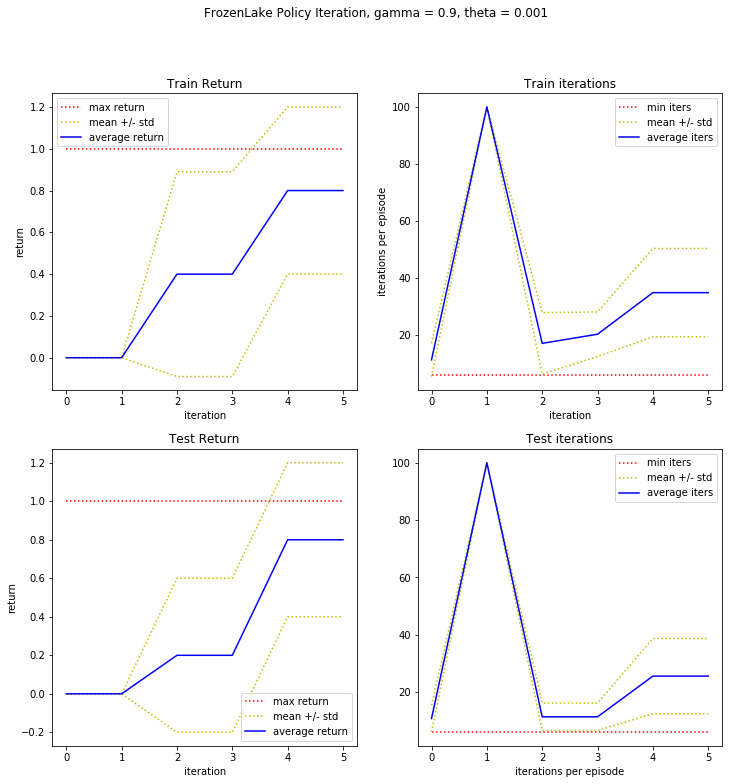

In [27]:
# plot best hyperparameter search results
title = 'FrozenLake Policy Iteration, gamma = ' + str(PI_frozen_lake['gamma']) + ', theta = ' + str(PI_frozen_lake['theta'])  
plot_results(PI_frozen_lake['I'], max_reward, min_iters, title)

With policy iteration we are able to achieve and average train and test reward of $0.8$ with an average iterations per episode of $34.8$ and $25.6$ for train and test respectively.  We can see a clear improvement in the policy over time, since in every iteration of policy improvement our policy is at least as good as the previous.  We can also see the trade off between the number of iteration per episode and the return.  In general, as our policy improves it takes longer to reach end of an episode (excluding the first iteration where the agent likely gets stuck running into the edge of the grid until the 100 iterations are over).  This longer time makes sense as the agent attempts to avoid falling into holes as much as possible and we are less likely to fall into holes causing an early end in the episode.  

Comparing the preformance across various values of $\gamma$ and $\theta$, we can see that preformance remains relatively stable with some exceptsions of the small $\gamma$ values or large $\theta$ values.  The small discount rates likely cause the policy iteration to not converge to as good of results as there is only a single reward at the end of the episode, so the policy would be based on trying to get to that reward in fewer iterations per episode to maximize the recieve a reward that has not been discounted as heavily.  This likely creates a higher risk of falling into the hole with a more agggressive strategy.  For the larger values of $\theta$ it is likely that our policy evaluation step is just not converging to a small enough value, leading to suboptimal value functions.

## Value Iteration

In [0]:
train_runs = 5
test_runs = 5
test_freq = 10

env = gym.make('FrozenLake-v0')

max_reward = 1
min_iters = 6
env_max_iter = 100

seed = 0

thetas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9]
gammas = [0.50, 0.70, 0.80, 0.90, 0.95, 0.99]
func = ValueIteration

In [29]:
VI_frozen_lake = hyperparam_search(gammas, 
                                    thetas, 
                                    func, 
                                    train_runs, 
                                    test_runs, 
                                    test_freq, 
                                    env, 
                                    env_max_iter, 
                                    seed)



Hyperparameter search over gamma and theta:
  gamma=0.5, theta=0.1
    Average train return: 0.0
    Average train iters: 100.0
    Average test return: 0.0
    Average test iters: 100.0
New optimal hyperparameters
  gamma=0.5, theta=0.01
    Average train return: 0.0
    Average train iters: 24.2
    Average test return: 0.0
    Average test iters: 100.0
  gamma=0.5, theta=0.001
    Average train return: 0.4
    Average train iters: 17.0
    Average test return: 0.0
    Average test iters: 100.0
  gamma=0.5, theta=1e-05
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
New optimal hyperparameters
  gamma=0.5, theta=1e-07
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.5, theta=1e-09
    Average train return: 0.4
    Average train iters: 20.2
    Average test return: 0.2
    Average test iters: 11.4
  gamma=0.7, theta=0.1
    Average train 

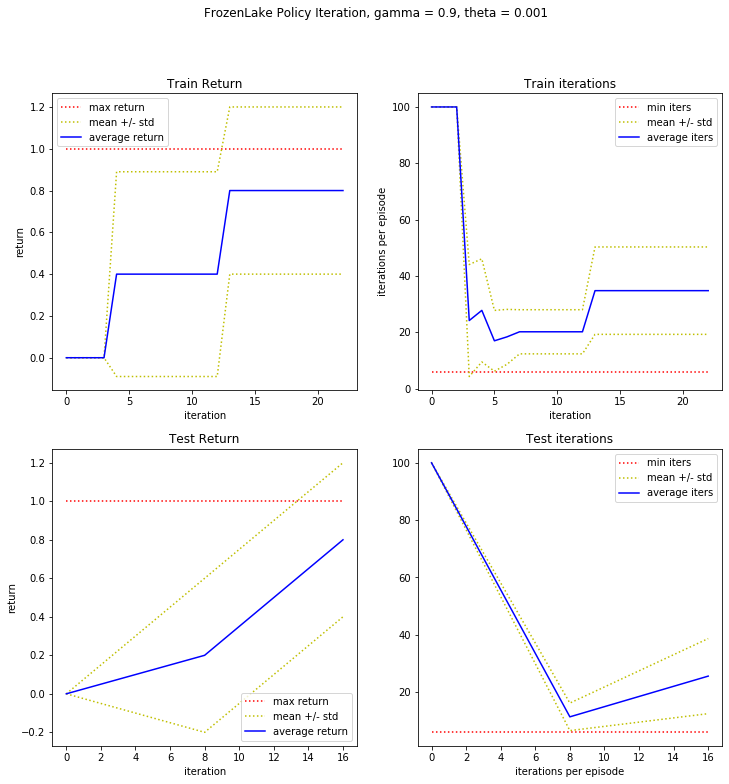

In [30]:
# plot best hyperparameter search results
title = 'FrozenLake Policy Iteration, gamma = ' + str(VI_frozen_lake['gamma']) + ', theta = ' + str(VI_frozen_lake['theta'])  
plot_results(VI_frozen_lake['I'], max_reward, min_iters, title)

With value iteration we are able to achieve the same average returns and iterations per step as policy iteration.  From the graphs we can see that the convergence to a new policy takes more iterations of value iteration.  We also appear to have a policy that remains fixed for several iterations of value iteration.  This is due to the fact that an incremental change in the value function does not nessescarily change the greddy action with respect to the policy.  

Comparing the preformance across various values of $\gamma$ and $\theta$, have similar results for low values of $\gamma$ and high values of $\theta$, which makes sense given the context of the Frozen Lake enviornment and how the reward is computed.  

In [31]:
# do we converge to the same policy?
np.sum(np.abs(PI_frozen_lake['pi'] - VI_frozen_lake['pi']))

0

In [32]:
# do we converge to the same policy?
np.sum(np.abs(PI_frozen_lake['v'] - VI_frozen_lake['v']))

0.0008969434307161128

Looking at a comparison between the policy achieved by policy and value we actually achieve an identical policy.  This does not hold in general since there can be multiple optimal policies.  The values functions are actually quite similar as well, differing by less that $0.000896$ in their L1 distance over 16 states.  

# Taxi

## Policy Iteration

In [0]:
train_runs = 5
test_runs = 5
test_freq = 2 # decrease test frequeny because policy iteration convergees qiuckly

env = gym.make('Taxi-v3')

# These rewards would occur in the case where the driver does not need to make any moves to complete the episode
# and receives the reward immediately. This may be an overestimate depoending if that situation is possible.
max_reward = 20
min_iters = 0

# note that the game actually runs for 200 iterations, but for readability of the graphs we will terminate
# after 50 iterations in order to not recieve extremely negative rewards initially.  
env_max_iter = 50 

seed = 0

thetas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9]
gammas = [0.75, 0.80, 0.90, 0.95, 0.99]

func = PolicyIteration

In [34]:
PI_taxi = hyperparam_search(gammas, 
                            thetas, 
                            func, 
                            train_runs, 
                            test_runs, 
                            test_freq, 
                            env, 
                            env_max_iter, 
                            seed)

Hyperparameter search over gamma and theta:
  gamma=0.75, theta=0.1
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
New optimal hyperparameters
  gamma=0.75, theta=0.01
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=0.001
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=1e-05
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=1e-07
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=1e-09
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.8, theta=0.1
    Average train return: 7.6
    Average tr

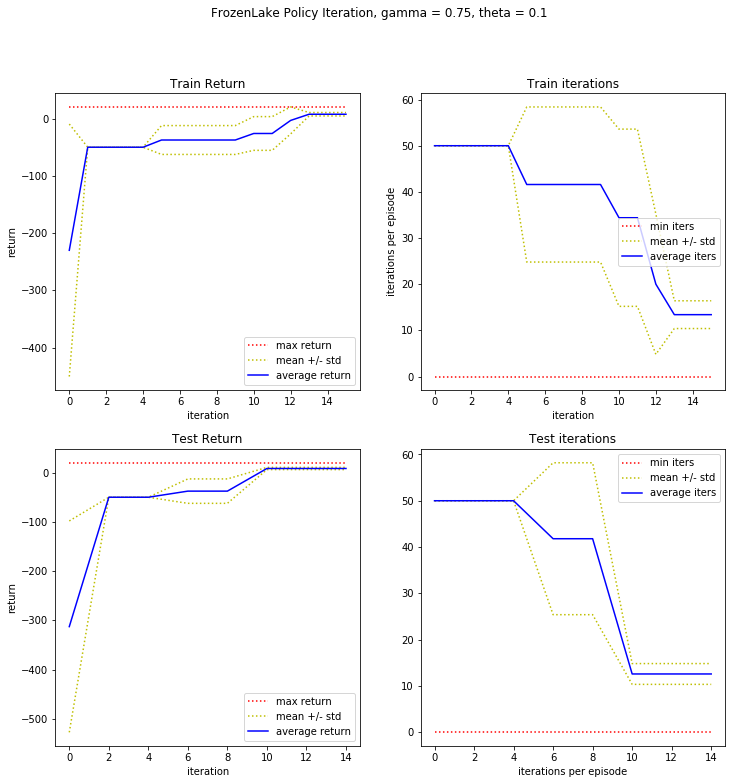

In [35]:
# plot best hyperparameter search results
title = 'FrozenLake Policy Iteration, gamma = ' + str(PI_taxi['gamma']) + ', theta = ' + str(PI_taxi['theta'])  
plot_results(PI_taxi['I'], max_reward, min_iters, title)

For policy evaluation in the Taxi enviornment we can see that the relationship between the return and iterations per episode is inversly related.  This is due to the penalization of $-1$ for each step that the agent takes, so maximizing reward is actually directly related to minimizing the steps until completion.  We can also see that this enviornment is less sensitive to the hyperparameters in compariosn to frozen lake.  In fact, we actually obtain the same preformance regardless ot the choice of parameters.  One reason for this could be that the policy's goal is to essentially minimize the duration in the enviornment, so even with a lower discount rate we will still want to finish the episode as fast as possible in order to  get maximize the reward (remaining in will just contribe $-\gamma^k$ at the $k$ iteration for every iteration we do not complete the task.  The reward of $20$ will also be further discounted so achieving this as early as possible is optimal). 

Another observation we can make is that in the first couple iterations of policy iteration the policy quickly begins to avoid traffic violations which have high negative cost, then begins to minimize the number of iterations.  

## Value Iteration

In [0]:
train_runs = 5
test_runs = 5
test_freq = 2 # decrease test frequeny because value iteration convergees qiuckly

# These rewards would occur in the case where the driver does not need to make any moves to complete the episode
# and receives the reward immediately.  This may be an overestimate depoending if that situation is possible.
max_reward = 20
min_iters = 0
env = gym.make('Taxi-v3')

# note that the game actually runs for 200 iterations, but for readability of the graphs we will terminate
# after 50 iterations in order to not recieve extremely negative rewards initially.  
env_max_iter = 50 

seed = 0

thetas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9]
gammas = [0.75, 0.80, 0.90, 0.95, 0.99]
func = ValueIteration

In [37]:
VI_taxi = hyperparam_search(gammas, 
                            thetas, 
                            func, 
                            train_runs, 
                            test_runs, 
                            test_freq, 
                            env, 
                            env_max_iter, 
                            seed)

Hyperparameter search over gamma and theta:
  gamma=0.75, theta=0.1
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
New optimal hyperparameters
  gamma=0.75, theta=0.01
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=0.001
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=1e-05
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=1e-07
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.75, theta=1e-09
    Average train return: 7.6
    Average train iters: 13.4
    Average test return: 8.4
    Average test iters: 12.6
  gamma=0.8, theta=0.1
    Average train return: 7.6
    Average tr

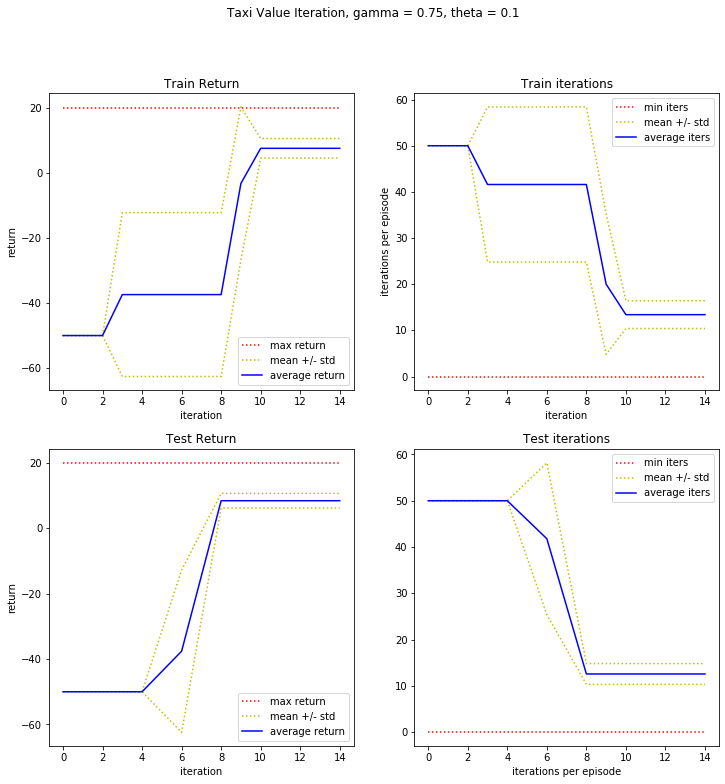

In [38]:
# plot best hyperparameter search results
title = 'Taxi Value Iteration, gamma = ' + str(VI_taxi['gamma']) + ', theta = ' + str(VI_taxi['theta'])  
plot_results(VI_taxi['I'], max_reward, min_iters, title)

The results for value iteration are quite consistent with policy iteration.  We achieve the same average return and  iterations per step.  Since the $\gamma$ and $\delta$ are low and high respectively we are actually able to converge in very few iterations for this enviornment.  We can even see in the last $4/14$ iterations we actually still do not improve, thus the $\theta=0.1$ appears to be sufficient for convergence.

In [39]:
# do we converge to the same policy?
np.sum(np.abs(PI_taxi['pi'] - VI_taxi['pi']))

0

In [40]:
# do we converge to the same value functions?
np.sum(np.abs(PI_taxi['v'] - VI_taxi['v']))

6.86079185141085

For this enviornment, looking at the policy and value functions obtained through policy and value iteration, we can see that again we achieve the same policy.  This result is not nessecarily guranenteed in genereal, so looking at the difference in value functions is more reasonable.  The L1 distance between value functions is quite small as well, as the $6.86$ is the sum of distance between 500 state value estimates.  So policy and value iteration converge to a relatively close value function.  

# Complexity

For the time and space complexity of these algorithms we can consider the simplified pseudocode from the
lecture slides as these implementations of policy and value iteration are equivalent minus some constant time 
implementation details.  In the complexity we will let $|S|$, $|A|$, $|R|$,  denote the number of states, actions, and rewards respectively.  We will also exclude the additional complexity required to evaluate the policy on instances as these are not nessecary for the algorithm to be run.  For the input to the algorithms we will assume that we are only given a function $p(s',r|s,a)$ and if we want to compute a transition matrix or expectation return vectors we will need iterate over all $s',r$ pairs.  This will increase space and time complexity should we desire to compute those however if we have access to transition matricies and expected return vectors, then time/space complexity will differ.  We will also assume knowledge of all $s\in S$, $r\in R$, and $a\in A$.  

## Policy Iteration

![Policy Iteration](https://drive.google.com/uc?export=view&id=1xyzjPMRhHID_tcUxLKRk_ZbZYlGZOdAP)



For policy iteration we can break it up into 3 parts.  The initialization, evaluation, and improvement stages.


**Initialization:**

The initialization step has time and space complexity $O(|S|)$ as we initialize two arrays of size $|S|$.

**Evaluation:**
Assuming the value iteration takes $O(I_e)$ iterations to converge we will bound the complexity of the operations within the convergence step.  The assignment of $\Delta$ is a constant time operation.  Following this we have a loop over the states, which computes an assignment operation to $v$ and and update to $\Delta$ which require constant time and space.  There is also the computation to update $V(s)$, which computes a summation over the state and action spaces, resulting in a complexity of $O(|S||R|)$.  Thus, the total complexity of the for loop is given by $O(|S|^2|R|)$.  The final operation is just a constant time comparison to check if we should exit the loop.  So the total running time of the convergence of the value function is given by $O(I_e|S|^2|R|)$.


**Improvement:**
Let $I_{i}$ denote the number of policy evaluation steps that need to be done (i.e. until the policy is stable).  For policy improvement we have the initialization of $policy-stable$, which requires constant time and space. The first loop updates each of the action for each of the $|S|$ states.  Within this loop the first and last steps are constant time operations as the are assignment and conditional statements.  The $\arg\max$ operation over $|A|$ actions which sums of the state and reward space, giving a total complexity of $O(|A||R||S|)$.  Thus the loop has a total complexity bounded by  $O(|A||S|^2|R|)$.  The next step will call the policy evaluation step, which requires $O(I_{e}|S|^2|R|)$.  Thus the complexity is bounded by the greater of these two operations (which can be problem dependent), so we have a total time complexity of $O(I_{i}(I_{e}|S|^2|R| + |A||S|^2|R|))$.  

**Notes on improving complexity:**
If we consider the vectorized form of the Bellman equation we can get a different result in terms of time and space complexity.  To do this we need to compute the expectation of the reward, $R_\pi\in\mathbb{R}^{|S|}$, and the transition probability matrix, $P_\pi \in\mathbb{R}^{|S|\times|S|}$ for each policy $\pi$.  These require $O(|S|^2|R|)$ time complexity and $O(|S|^2)$ space complexity to compute (which is bounded by $P_\pi$).  With these we can replace the summation operations with matrix multiplcation, giving a $O(|S|^2|A|)$ operation to compute the $\arg\max$ in policy improvement, and a $O(|S|^2)$ operation in the update to $V(S)$ in policy evaluation.  This would reduce the overall complexity to $O(I_{i}(I_{e}|S|^2 + |A||S|^2 + |S|^2|R|))$.

We can also observe that with $P_\pi$ and $R_\pi$ we can analytically preform the policy evaluation step.  By Bellman's equation we have $V_\pi = R_\pi + \gamma P_\pi V_\pi$, where $V_\pi\in\mathbb{R}^{|S|}$ is the vector form of the value function.  Solving for $V_\pi$ gives $V_\pi = R_\pi(I - \gamma P_\pi)^{-1}$, which is bounded in time complexity by the $O(|S|^3)$ matrix inverse operation.  Thus we can obtain a time complexity of  $O(I_{i}(|S|^3 + |A||S|^2 + |S|^2|R|))$ with a space complexity of $O(|S|^2)$.

## Value Iteration 

![Value Iteration](https://drive.google.com/uc?export=view&id=1nVYy2vVTTyl69XA_4dr_UgliPBAew0BF)

The initialization will require $O(|S|)$ in time and space to initialize and store an array of size $|S|$.  Assuming the value iteration takes $O(I)$ iterations to converge we will bound the complexity of the operations within the convergence step.  The assignment of $\Delta$ is a constant time operation.  Following this we have a loop over the states, which computes an assignment operation to $v$ and and update to $\Delta$ which require constant time and space.  There is also the computation of the greedy action, which computes a max over the $|A|$ actions.  The computation within the max is bounded by the state and reward space throught the summation, requiring giving a cost of $O(|S||R||A|)$.  Thus, the total complexity of the for loop is given by $O(|S|^2|R||A|)$.  The final operation is just a constant time comparison to check if we should exit the loop.  So the total running time of the convergence of the value function is given by $O(I|S|^2|R||A|)$.  The final operation to compute the policy is similar the $\max$ operation within the loop and is again done for each state, thus we have a total complexity of $O(|S|^2|R||A|)$.  To bound the entire algorithm we have that the complexity of the algorithm bounded by the value iteration until convergence which gives a bound of $O(I|S|^2|R||A|)$.

As the most space we are using is two arrays of size $|S|$ to record the policy and values, plus some constant space for storing values, we have a space compleixty bounded by $O(|S|)$.